In [1]:
import pandas as pd
import numpy as np
#from funcs import *
import matplotlib.pyplot as plt  
from functools import reduce
import seaborn as seabornInstance 
from matplotlib.pyplot import subplot
import operator as op
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
import cvxpy as cp
from quadratic1 import *


In [279]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-2].values

#Number of deaths
y = pd.read_csv('data.csv').iloc[:,-2].values

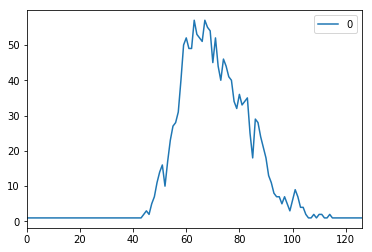

In [280]:
pd.DataFrame(y).plot()

#### To find best smoothing

In [282]:
from tqdm import tqdm

training_poss = np.arange(3, 50)
loss_even = []
loss_odd = []
for tr in tqdm(training_poss):
    loss_even.append(find_best_K(X, y, 'even', training_size=tr)[1])
    loss_odd.append(find_best_K(X, y, 'odd', training_size=tr)[1])



100%|██████████| 47/47 [02:51<00:00,  3.53s/it]


(0.6999999999999997, 51.3, 0.4827009796221064, 6.028314902362848)

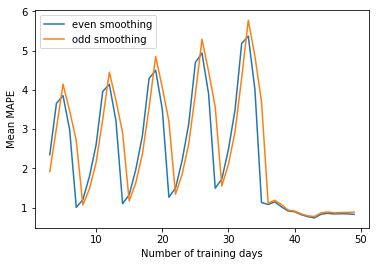

In [283]:
x_data = training_poss
y_data0 = loss_even
y_data1 = loss_odd

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
ax.plot(x_data, y_data0, label='even smoothing')
ax.plot(x_data, y_data1, label='odd smoothing')
plt.legend()
#plt.title('Mean MAPE loss based on \n the number of training days')

#ax.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
ax.set_xlabel('Number of training days')
ax.set_ylabel('Mean MAPE')

#plt.axvline(x=tr)
#min_ = 'K= ' + str(tr)
#
#ax.annotate(min_, xy=(tr, min(losses[idx])+2))
ax.axis()

In [284]:
minimums = [np.min(loss_even), np.min(loss_odd)]
losses = [loss_even, loss_odd]
idx = np.argmin(minimums) #if 0 even if 1 odd
tr = training_poss[np.argmin(losses[idx])]
parity = ''
if idx == 0:
    K = find_best_K(X, y, parity='even',training_size = tr)[0]
    X = apply_smoothing(X, K, 'even') 
    parity = 'even'
else:
    K = find_best_K(X, y, parity='odd',training_size = tr)[0]
    X = apply_smoothing(X, K, 'odd') 
    parity = 'odd'


In [285]:
print('The minimum loss of ', min(losses[idx]), ' is obtained using ', tr, ' training days with an', parity, 'parity and K=', K) 

The minimum loss of  0.7347743397466856  is obtained using  43  training days with an even parity and K= 8


In [155]:
def exponential_smoothing(y, rho, K):
    const = (1-rho)/(1-rho**(K+1))
    new_y = []
    
    # range of x
    r_y = np.arange(K, len(y)-K)

    # range of k
    r_k = np.arange(0,K)
    
    for i in range(len(y)):
        if i not in r_y:
            new_y.append(y[i])
        else:
            ls = []
            for k in r_k:
                ls.append(int(const*rho**k*y[i-k]))
            new_y.append(np.sum(ls))
                
    return new_y

In [2]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-2].values

#Number of deaths
y = pd.read_csv('data.csv').iloc[:,-2].values

tr1 = 44

X0 = apply_smoothing(X, 8, 'even')
tr0 = 43

In [7]:
def compute_preds(X, tr):
    #X = apply_smoothing(X, 6, 'even') 

    #tr = training_poss[np.argmin(loss)]

    N = X.shape[1]
    splits = int(np.floor((X.shape[0] - tr)/7))

    # list of the mape for a given split, this list is reinitialized for every K
    temp_mapes = []
    y_vals = []
    gammas = []
    y_preds = []

    for i in range(splits):

        begin = 7*i
        end = tr + 7*i

        X_tr = X[begin:end,:]
        y_tr = y[begin:end]

        X_te = X[end:end+7,:]
        y_te = y[end:end+7]


        index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N)
        P, q, G, h = generate_params(X_tr, y_tr, index, N, 10e-15)
        gamma = cvxopt_solve_qp(P, q, G, h)
        y_pred = X_te@gamma
        y_pred[y_pred < 1] = 1
        y_pred = np.floor(y_pred)
        y_preds.append(y_pred)
        gammas.append(gamma)
        temp_mapes.append(mape(y_te, y_pred))

    print(np.mean(temp_mapes))
    y_preds = [item for sublist in y_preds for item in sublist]
    y_preds_saved = y_preds
    y_preds = np.append(y[:tr],y_preds)
    y_preds = exponential_smoothing(y_preds, 0.65, 7)


    return y_preds, gammas
    #y_preds = exponential_smoothing(y_preds, 0.9, 7)


In [8]:
y_normal, gammas_normal = compute_preds(X, tr1)
y_smoothed, gammas_smoothed = compute_preds(X0, tr0)

y_normal = [y_p if y_p > 1 else 1 for y_p in y_normal]
y_smoothed = [y_p if y_p > 1 else 1 for y_p in y_smoothed]

0.8108060153813986
0.7347743397466856


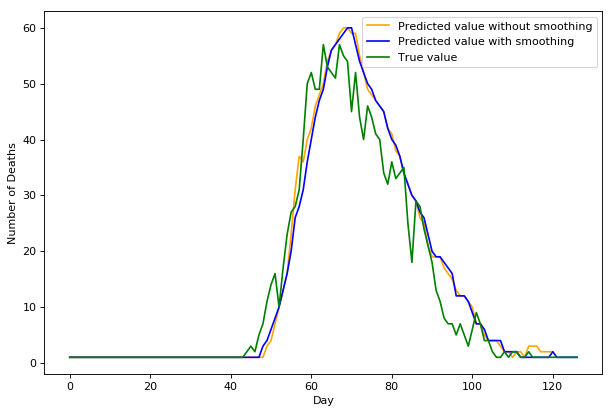

In [9]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot('111')
plt.plot(y_normal, 'orange', y_smoothed, 'blue', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value without smoothing','Predicted value with smoothing', 'True value'])
#plt.title('Daily number of deaths in France due to the Covid-19')

In [18]:
len(gammas_normal)

11

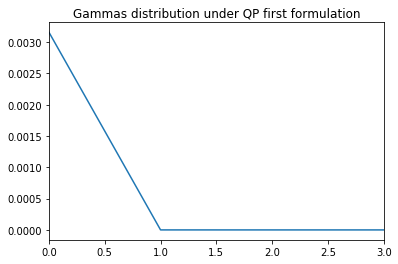

In [26]:
pd.DataFrame(gammas_normal[10]).plot(title='Gammas distribution under QP first formulation',legend=None)

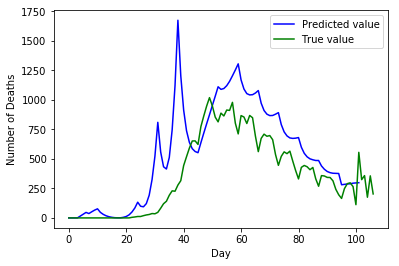

In [235]:
#X = apply_smoothing(X, 6, 'even') 

#tr = training_poss[np.argmin(loss)]

N = X.shape[1]
splits = int(np.floor((X.shape[0] - tr)/7))
    
# list of the mape for a given split, this list is reinitialized for every K
temp_mapes = []
y_vals = []
gammas = []
y_preds = []

for i in range(splits):
            
    begin = 7*i
    end = tr + 7*i

    X_tr = X[begin:end,:]
    y_tr = y[begin:end]

    X_te = X[end:end+7,:]
    y_te = y[end:end+7]


    index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N)
    P, q, G, h = generate_params(X_tr, y_tr, index, N, 10e-15)
    gamma = cvxopt_solve_qp(P, q, G, h)
    y_pred = X_te@gamma
    y_pred[y_pred < 1] = 1
    y_preds.append(y_pred)
    gammas.append(gamma)

y_preds = [item for sublist in y_preds for item in sublist]
y_preds_saved = y_preds
y_preds = np.append(y[:tr],y_preds)
y_preds = exponential_smoothing(y_preds, 0.65, 7)
y_preds = [y_p if y_p > 1 else 1 for y_p in y_preds]
#y_preds[y_preds < 1] = 1
#y_preds = exponential_smoothing(y_preds, 0.9, 7)
plt.plot(y_preds, 'b', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value','True value'])
#plt.title('Daily number of deaths in France due to the Covid-19')

TypeError: '>' not supported between instances of 'list' and 'int'

### To find best model without smoothing

In [179]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-2].values

#Number of deaths
y = pd.read_csv('data.csv').iloc[:,-2].values

In [180]:
training_poss = np.arange(3, 60)
loss = []

for tr in tqdm(training_poss):

    N = X.shape[1]
    splits = int(np.floor((X.shape[0] - tr)/7))

    # list of the mape for a given split, this list is reinitialized for every K
    temp_mapes = []
    y_vals = []
    gammas = []
    y_preds_no_smoothing = []

    for i in range(splits):

        begin = 7*i
        end = tr + 7*i

        X_tr = X[begin:end,:]
        y_tr = y[begin:end]

        X_te = X[end:end+7,:]
        y_te = y[end:end+7]


        index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N)
        P, q, G, h = generate_params(X_tr, y_tr, index, N, 10e-15)
        gamma = cvxopt_solve_qp(P, q, G, h)
        y_pred = X_te@gamma
        y_pred[y_pred < 1] = 1
        y_preds_no_smoothing.append(y_pred)
        gammas.append(gamma)
        temp_mapes.append(mape(y_te,y_pred))
    
    loss.append(np.mean(temp_mapes))

tr = np.argmin(loss)

100%|██████████| 57/57 [00:07<00:00,  5.80it/s]


In [181]:
print('The minimum loss of ', np.min(loss), ' is obtained using ', training_poss[np.argmin(loss)], 'training days') 


The minimum loss of  0.7799282529919389  is obtained using  10 training days


No handles with labels found to put in legend.


(0.19999999999999973, 61.8, -49.11197214651469, 1041.5921808150679)

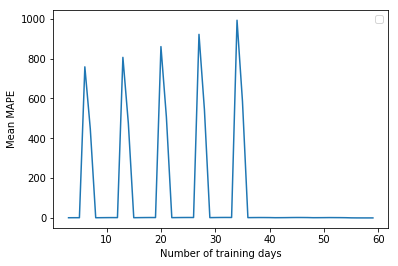

In [177]:
x_data = training_poss
y_data = loss

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_data, y_data)
plt.legend()
#plt.title('Mean MAPE loss based on \n the number of training days')

#ax.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
ax.set_xlabel('Number of training days')
ax.set_ylabel('Mean MAPE')

#plt.axvline(x=tr)
#min_ = 'K= ' + str(tr)
#
#ax.annotate(min_, xy=(tr, min(losses[idx])+2))
ax.axis()

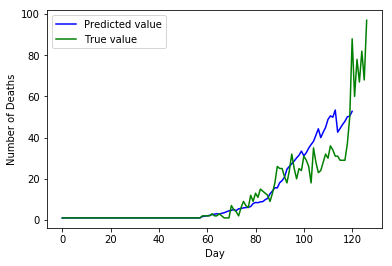

In [178]:
#X = apply_smoothing(X, 6, 'even') 

tr = training_poss[np.argmin(loss)]

N = X.shape[1]
splits = int(np.floor((X.shape[0] - tr)/7))
    
# list of the mape for a given split, this list is reinitialized for every K
temp_mapes = []
y_vals = []
gammas = []
y_preds_no_smoothing = []

for i in range(splits):
            
    begin = 7*i
    end = tr + 7*i

    X_tr = X[begin:end,:]
    y_tr = y[begin:end]

    X_te = X[end:end+7,:]
    y_te = y[end:end+7]


    index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N)
    P, q, G, h = generate_params(X_tr, y_tr, index, N, 10e-15)
    gamma = cvxopt_solve_qp(P, q, G, h)
    y_pred = X_te@gamma
    y_pred[y_pred < 1] = 1
    y_preds_no_smoothing.append(y_pred)
    gammas.append(gamma)

y_preds_no_smoothing = [item for sublist in y_preds_no_smoothing for item in sublist]
y_preds_saved = y_preds
y_preds_no_smoothing = np.append(y[:tr],y_preds_no_smoothing)
plt.plot(y_preds_no_smoothing, 'b', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value','True value'])
#plt.title('Daily number of deaths in France due to the Covid-19')

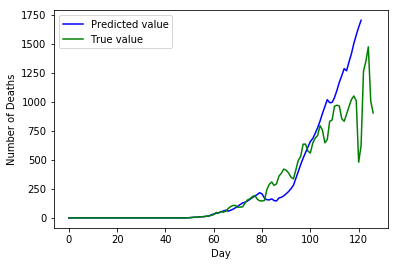

In [173]:
#X = apply_smoothing(X, 6, 'even') 

tr = training_poss[np.argmin(loss)]

N = X.shape[1]
splits = int(np.floor((X.shape[0] - tr)/7))
    
# list of the mape for a given split, this list is reinitialized for every K
temp_mapes = []
y_vals = []
gammas = []
y_preds_no_smoothing = []

for i in range(splits):
            
    begin = 7*i
    end = tr + 7*i

    X_tr = X[begin:end,:]
    y_tr = y[begin:end]

    X_te = X[end:end+7,:]
    y_te = y[end:end+7]


    index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N)
    P, q, G, h = generate_params(X_tr, y_tr, index, N, 10e-15)
    gamma = cvxopt_solve_qp(P, q, G, h)
    y_pred = X_te@gamma
    y_pred[y_pred < 1] = 1
    y_preds_no_smoothing.append(y_pred)
    gammas.append(gamma)

y_preds_no_smoothing = [item for sublist in y_preds_no_smoothing for item in sublist]
y_preds_no_smoothing = exponential_smoothing(y_preds_no_smoothing, 0.65, 7)
y_preds_no_smoothing = np.append(y[:tr],y_preds_no_smoothing)
y_preds_no_smoothing[y_preds_no_smoothing < 1] = 1
plt.plot(y_preds_no_smoothing, 'b', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value','True value'])
#plt.title('Daily number of deaths in France due to the Covid-19')

In [53]:
np.min(loss)

0.49264730098866566

In [5]:
def apply_smoothing_y(y, K, parity):

    y = gauss_filter(y, K, parity=parity)
    
    return y

def exponential_smoothing(x, rho, K):
    const = (1-rho)/(1-rho**(K+1))
    new_x = []
    
    # range of x
    r_x = np.arange(K, len(x)-K)

    # range of k
    r_k = np.arange(0,K)
    
    for i in range(len(x)):
        if i not in r_x:
            new_x.append(x[i])
        else:
            ls = []
            for k in r_k:
                ls.append(int(const*rho**k*x[i-k]))
            new_x.append(np.sum(ls))
                
    return new_x

In [438]:
def find_best_alpha(y_p, y_test):
    """Returns optimal alpha such that MAPE error is minimized,along with the MAPE index error in question, and its value"""
    alphas = [round(0.05*i, 2) for i in range(20)]
    Ks = np.arange(1, 5)
    y_test = y_test[tr:]
    mapes = np.ones((len(Ks), len(alphas)))
    len_ = min(len(y_test[tr:]),len(y_p))
 
    for i, K in enumerate(Ks):
        for j, alpha in enumerate(alphas):
            y_p = exponential_smoothing(y_p, alpha, K)
            mapes[i,j] = mape(y_test[len_], y_p)
    return Ks[(np.unravel_index(np.argmin(mapes, axis=None), mapes.shape))[0]], alphas[(np.unravel_index(np.argmin(mapes, axis=None), mapes.shape))[1]]


In [443]:
K, alpha = find_best_alpha(y_preds, y)
y_preds = exponential_smoothing(y_preds, alpha, 5)

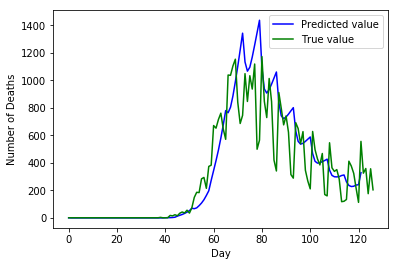

In [444]:
plt.plot(y_preds, 'b', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value','True value'])

In [396]:
mape(y[tr:],y_preds)

ValueError: operands could not be broadcast together with shapes (124,) (122,) 

In [276]:
gamma

array([1.17839516e-03, 9.98528911e-08, 1.00937558e-07, 1.00150432e-07,
       1.00060882e-07, 9.98781763e-08, 9.98604997e-08, 9.99128668e-08,
       9.98903466e-08, 9.98534190e-08, 9.98389930e-08, 9.99415102e-08,
       1.00276565e-07, 9.98643395e-08, 9.98414225e-08])

In [277]:
gammas

[array([7.21611258e-06, 1.00013065e-07, 1.00074614e-07, 1.00075270e-07,
        1.00072667e-07, 1.00042718e-07, 1.00038368e-07, 9.99450532e-08,
        9.99390717e-08, 9.99278212e-08, 9.99291909e-08, 9.99267968e-08,
        9.99230926e-08, 9.99236264e-08, 9.99241749e-08]),
 array([2.59442473e-02, 2.48423048e-02, 5.14344432e-05, 2.28002143e-05,
        1.60710577e-05, 3.48314579e-05, 3.45307754e-02, 3.29934534e-02,
        3.41583335e-04, 7.61101226e-02, 7.61101229e-02, 7.61101226e-02,
        2.81454111e-04, 7.05185522e-05, 4.08019928e-05]),
 array([0.05472707, 0.09713343, 1.21180909, 0.03387336, 0.00996835,
        0.0080824 , 0.00963139, 0.00793439, 0.03055433, 0.0471084 ,
        0.01134715, 0.01272062, 0.01089764, 0.01252349, 0.00231002]),
 array([5.33845800e-04, 1.10535223e-04, 6.71316378e-04, 1.33064098e-03,
        7.27885441e-04, 8.89029154e-02, 1.50312236e-01, 4.18708814e-04,
        1.44577318e+00, 5.65751607e+02, 9.35855460e-04, 1.11133948e-04,
        1.76733377e-03, 4.3477

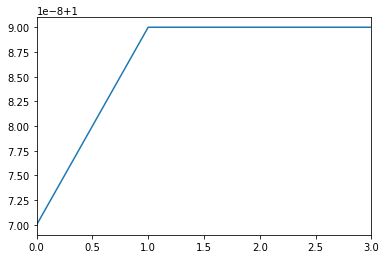

In [219]:
pd.DataFrame({'Gamma': gammas[0]}).plot(legend=None)
#title='Gamma distribution for model created on 13th chunk of data', 


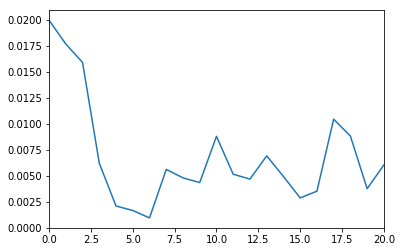

In [107]:
pd.DataFrame({'Gamma': gammas[0]}).plot(legend=None)
